# Onboarding Challenge

The aim of this notebook is to show how to detect eye blinks and how to filter this artefact from the EEG signal. To achieve this, we will try different ways to analyze the signal.

The following [Udemy course by Mike X Cohen](https://www.udemy.com/signal-processing/) is incredibly useful and is a nice introduction to digital signal processing tools.

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from time import strftime, gmtime
from csv import reader
from collections import OrderedDict
import numpy as np
import copy

# Read the prerecorded file
Before doing anything with our data, we want to see what it looks like.

In [2]:
EEG_DATA_FILE_NAME = os.path.join("eeg-records", "eeg_and_eye_blinks_recording.csv")

In [3]:
def read_eeg_file(csv_file_path):
    eeg_data = OrderedDict()

    with open(csv_file_path, newline='') as eeg_file:
        csv_reader = reader(eeg_file, delimiter=',')
        eeg_data = OrderedDict({key:[] for key in next(csv_reader)})  # Use the headers as key of eeg_data dict
        for samples in csv_reader:
            for i, key in enumerate(eeg_data.keys()):
                eeg_data[key].append(float(samples[i])) # Add the sample to its channel list
    
    return eeg_data

eeg_data = read_eeg_file(EEG_DATA_FILE_NAME)

# This will set the time reference at 0 seconds.
eeg_data['timestamps'] = [float(data) - float(eeg_data['timestamps'][0]) for data in eeg_data['timestamps']]

Now that we have read our EEG data file, we want to plot it to see what it looks like. Note that we don't plot the Right Aux channel since this one was not used in the recording and only have useless noise.

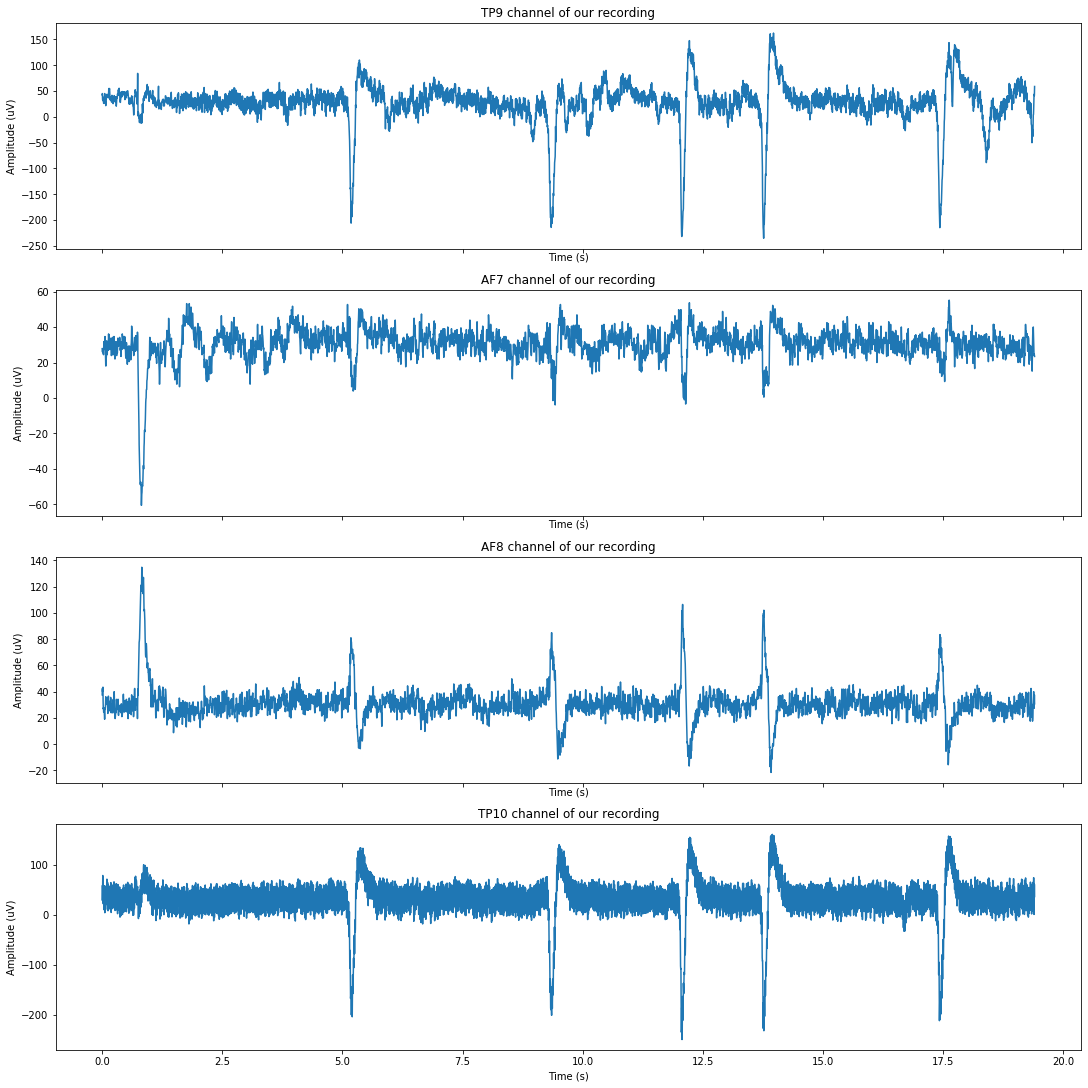

In [4]:
fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True, figsize=[15,15])

# Plot the TP9 channel
axes[0].set_title('TP9 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data['TP9'])

# Plot the AF7 channel
axes[1].set_title('AF7 channel of our recording')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (uV)')
axes[1].plot(eeg_data['timestamps'], eeg_data['AF7'])

# Plot the AF8 channel
axes[2].set_title('AF8 channel of our recording')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude (uV)')
axes[2].plot(eeg_data['timestamps'], eeg_data['AF8'])

# Plot the TP10 channel
axes[3].set_title('TP10 channel of our recording')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Amplitude (uV)')
axes[3].plot(eeg_data['timestamps'], eeg_data['TP10'])

# We're not plotting Right Aux channel since we're not using an extra channel.

As we can see, there are some huge spikes in the data. This is caused by the eye blinking that creates current in the electrodes. To understand how the eye blinking affects the EEG signal, we recommand watching [this video](https://www.youtube.com/watch?v=s1GknlqKGYo&list=PLxaiR6teSdjoEZWaDWm28A9QjFN7eguAp&index=4&t=0s). While recording these signals, we made sure to limit the EMG artefacts by not contracting face muscles. Otherwise, this would also have been a factor of signal contamination.

The TP channels seem to have more important spikes in amplitude than the AF channels. This is explained by the position of the reference electrode. Indeed, all EEG signals are the result of the potential at the electrode position minus the potential at the reference position. This means that the noise at the reference electrode is cancelled in all electrodes. TP spikes are negatives since a high potential is detected on the ref electrode, causing the TP channel to be substracted by a high number.

# Detect eye blinks

To begin, we'll filter the TP10 channel since it has the steepest curves when a blink occurs.

## Doing it the simple way

We can see that a blink artefact corresponds to a steep spike in the signal. For that channel, the amplitude goes down when the eye closes and goes up when it opens. So what we could to do is simply to apply a threshold on the absolute value of the amplitude. To pick the threshold, lets plot an histogram of the amplitude occurences. Then, we will set a threshold for the values we considered uncommon.

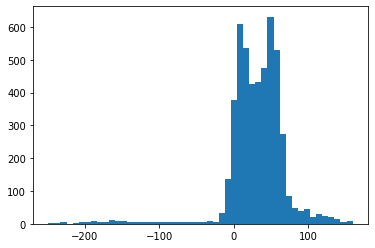

In [5]:
plt.hist(eeg_data['TP10'], 50)
plt.show()

We choose a threshold of 100 uV because we consider that superior amplitude values are uncommon. This is a completely  arbitrary choice based on our observation of the previous histogram.

We then apply the threshold on the amplitude, whereas the absolute value, of the signal. We create a time series with a `1` for every value of amplitude greater than the threshold, and `0` otherwise.

In [6]:
THRESHOLD = 100 # We picked this number based on the previous histogram.
blink_signal = [abs(amplitude) > THRESHOLD for amplitude in eeg_data['TP10']]

We then visualize the results of the applied threshold.

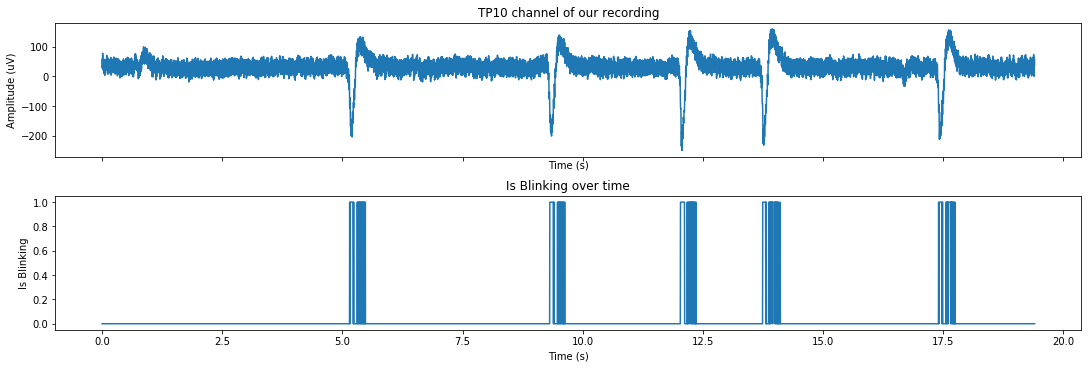

In [7]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data['TP10'])

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], blink_signal)

Yay! We indeed detected all the expected artefacts. However, the blink signal presents nasty oscillations since the original time series has its amplitude oscillates around our threshold value.

To remedy this, we can add some debouncing to the signal and ensure that we count only one rising edge for every blink.

In [8]:
DEBOUNCING_TIME = 0.1 # In seconds. We consider that we cannot blink more than once in that period.
FREQUENCY = 256
PERIOD = 1/FREQUENCY

def debounce_signal(signal):
    rising_edges = []
    falling_edges = []
    last_value = signal[0]

    # Find the edge indexes.
    for i, data in enumerate(signal):
        if data is not last_value:
            if last_value:
                falling_edges.append(i)
            else:
                rising_edges.append(i)
        last_value = data

    for i in falling_edges:
        next_rising_edge = next((index for index in rising_edges if index > i), None)
        if next_rising_edge is None:
            break
        
        # If the next rising edge is within the debouncing period, then set the blink signal to 1.
        falling_to_rising_idx_span = next_rising_edge - i
        if falling_to_rising_idx_span * PERIOD < DEBOUNCING_TIME:
            signal[i: next_rising_edge] = [True] * falling_to_rising_idx_span
    return signal

debounced_blink_signal = debounce_signal(blink_signal)

Let's plot this debounced signal.

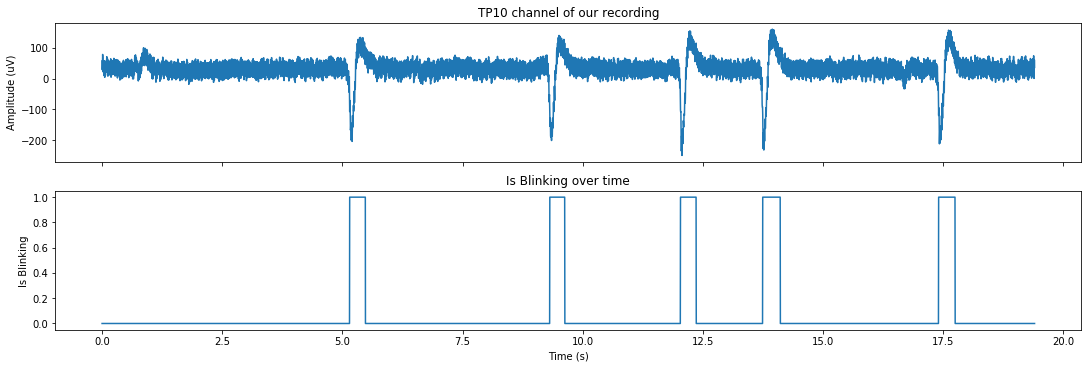

In [9]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data['TP10'])

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], debounced_blink_signal)

### Some issues with the previous method
The simple manual amplitude threshold value method is good, but is not the best criteria. To automatize this process and to get a more reliable criteria, we could use a z-score threshold based on the standard deviation of our signal.

## Using a Z-Score threshold
Since the Z-score of our signal can be semi-automatically calculated, this way of proceeding will work for every signal. We say semi-automatically calculated since we need to specify an arbitrary z-score threshold. This method although assumes there's a period of the recording where the subject doesn't blink.

Let's start by calculating the z-score of every data points based on the mean and standard deviation of an epoch with no eye blink.

In [10]:
# Where signal is the entire signal to convert and the baseline range is a tuple with the starting
# index and the ending index of the range of the signal that is used to establish the z-score criteria.
def convert_to_zscore(signal, baseline_range):
    baseline_mean = np.mean(signal[baseline_range[0]:baseline_range[1]])
    baseline_std_deviation = np.std(signal[baseline_range[0]:baseline_range[1]])
    z_scored_signal = (signal - baseline_mean) / baseline_std_deviation
    return (baseline_mean, baseline_std_deviation, z_scored_signal)

BASELINE_SAMPLES_RANGE = (0,int(4*FREQUENCY))  # 4 first seconds of data
(mean, std_deviation, eeg_data_zscore) = convert_to_zscore(eeg_data["TP10"], BASELINE_SAMPLES_RANGE)

Now that we calculated the z-score for every data points, lets set a z-score threshold to detect *abnormally distant* datapoints.

In [11]:
Z_SCORE_THRESHOLD = 4

Let's calculate the blink signal according to this new threshold and debounce it right away.

In [12]:
blink_signal = debounce_signal([abs(z_scored_data_point) > Z_SCORE_THRESHOLD for z_scored_data_point in eeg_data_zscore])

Lets plot all this to see if this worked...

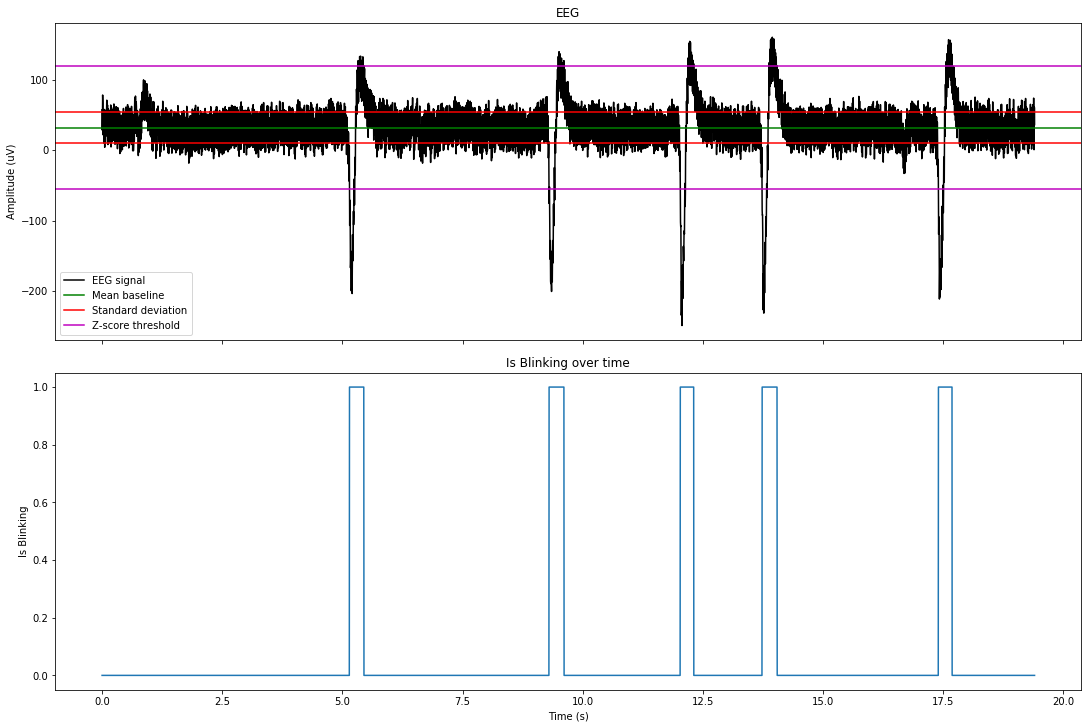

In [13]:
# plot zscored
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,10])
axes[0].set_title('EEG')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data["TP10"], 'black', label='EEG signal')
axes[0].axhline(y=mean, color='g', label='Mean baseline')
axes[0].axhline(y=mean + std_deviation, color='r', label='Standard deviation')
axes[0].axhline(y=mean - std_deviation, color='r')
axes[0].axhline(y=mean + Z_SCORE_THRESHOLD * std_deviation, color='m', label='Z-score threshold')
axes[0].axhline(y=mean - Z_SCORE_THRESHOLD * std_deviation, color='m')
axes[0].legend()

axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], blink_signal)

### Some issues with the previous method
We could hardly increase the z-score threshold value, because it wouldn't correctly detect the blink artefacts. For example, if we increase the z-score threshold value to 5 times the standard deviation, it would miss the positive peak associated with the eye opening.


## [TKEO algorithm](https://drive.google.com/open?id=1N9ARGXhnCmY9S7QUc8uIdMRM9L1OF6Ao)
A better solution could be to calculate the energy of the signal to increase the relative importance of the spikes. This could significally enhance our detection method and enable us to pick a z-score threshold value that works most of the time.

We will begin by applying this operator to our time series.

In [14]:
tkeo_eeg_data = copy.deepcopy(eeg_data['TP10'])

for i in range(1,len(tkeo_eeg_data)-1):
    tkeo_eeg_data[i] = eeg_data['TP10'][i]**2 - eeg_data['TP10'][i-1]*eeg_data['TP10'][i+1]

We will again calculate the z-score of every data points based on the mean and standard deviation of an epoch with no eye blink, but this time with the energy signal. The baseline will be the same as before.

In [15]:
(mean, std_deviation, tkeo_eeg_data_zscore) = convert_to_zscore(tkeo_eeg_data, BASELINE_SAMPLES_RANGE)

Let's calculate the blink signal and debounce it.

In [16]:
Z_SCORE_THRESHOLD = 4
blink_signal = debounce_signal([abs(z_scored_data_point) > Z_SCORE_THRESHOLD for z_scored_data_point in eeg_data_zscore])

We now plot the energy of the signal.

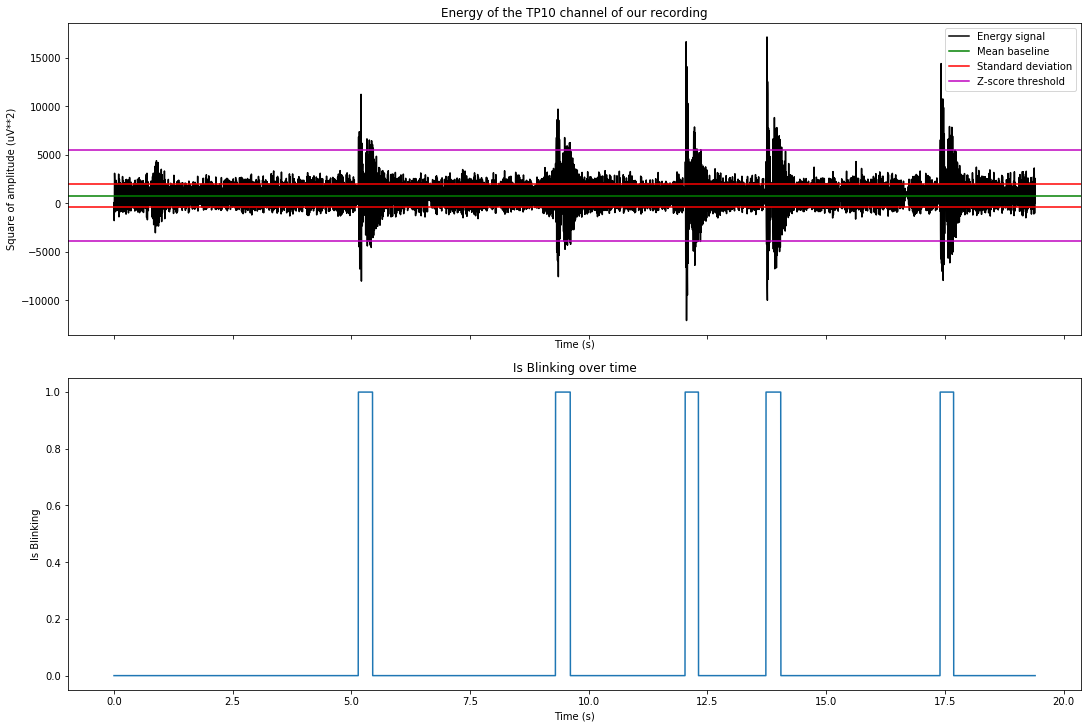

In [17]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,10])

axes[0].set_title('Energy of the TP10 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Square of amplitude (uV**2)')
axes[0].plot(eeg_data['timestamps'], tkeo_eeg_data, color='black', label='Energy signal')

axes[0].axhline(y=mean, color='g', label='Mean baseline')
axes[0].axhline(y=mean + std_deviation, color='r', label='Standard deviation')
axes[0].axhline(y=mean - std_deviation, color='r')
axes[0].axhline(y=mean + Z_SCORE_THRESHOLD * std_deviation, color='m', label='Z-score threshold')
axes[0].axhline(y=mean - Z_SCORE_THRESHOLD * std_deviation, color='m')
axes[0].legend()

axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], blink_signal)

### Conclusion about using TKEO 
It did not help because the relative importance of the signal's spikes is not big enough to differentiate itself from the rest of the signal when we use the TKEO operator (at least, that is what we think). However, we still think that it could help for signals with greater spikes relative to the surrounding points (like EMG).

# Record an EEG signal

Now that a prerecorded signal was processed, let's see if this works with your own eye's blinks.

The following script could need to be run several times before being able to connect the muse correctly (it tooks us up to 20 tries for example on linux). **Please check the [muse-lsl](https://github.com/alexandrebarachant/muse-lsl) README if you encounter any problem.**

In [ ]:
muses = list_muses()
if len(muses):
    stream_process = Process(target=stream, args=(muses[0]['address'],))
    stream_process.start()

Now that your muse is correctly connected and is streaming data to the muse-lsl lib, run the following block with the line corresponding to your operating system to plot the signal of your headset in real time.

In [ ]:
# view(backend="Qt5Agg") # Use this backend on Linux
# view(backend="MacOSX") # Use this backend on MacOS
# view(backend="TkAgg") # Use this backend on Windows

Please make sure you have a good signal in the viewer before running the next block. Once you'll run the next block, please blink your eyes a couple times **without bending the muscles of your forehead.** In order, to apply the z-score method, make sure to have a good signal without blink artefacts for the first 4 seconds of your recording. 

In [ ]:
DURATION = 20  # secs
RECORDING_PATH = os.path.join("eeg-records", "recording-%s.csv" % strftime("%Y-%m-%d-%H.%M.%S", gmtime()))

recording_process = Process(target=record, args=(DURATION, RECORDING_PATH))
recording_process.start()

### Test your own blinks!
Now that you have properly recorded your own EEG signal, let's detect your eye blinks by running all the previous code and make sure you change the eeg data file name.